# Setup Environment

In [5]:
!pip install locust -q
!pip install matplotlib -q
!pip install scipy -q

import os
import requests
import re, json
import scipy.stats
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math, functools
import timeit, time

HOST = "http://localhost:3000"
EXECUTION_TIME_PER_LOAD = "5min"
LOADS = range(1, 1001, 50)
WAIT_BETWEEN_EXECUTIONS_IN_S = 60
REPEAT_DATA_COLLECTION = 10

def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return {"mean": m, "confidence": h}

def logfile_names(repeat, load):
    prefixes = ["classic_", "extended_"]
    result = []
    for prefix in prefixes:
        result.append(prefix + str(load) + "_" + str(repeat) + ".log")
    return result

You are using pip version 10.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Experiment 2 - Accessing TimeMaps
Create a resource with 10,000 revisions and find a subset of revisions based on a defined datetime-range and vary that range.

## Create Revisions

In [3]:

#TODO Create Revisions
!locust -f create_tm.py -H {HOST} -u 1 -r 1 --run-time 500s --headless --only-summary --logfile create_tm.log


 Name                                                          # reqs      # fails  |     Avg     Min     Max  Median  |   req/s failures/s
--------------------------------------------------------------------------------------------------------------------------------------------
 POST /timemap_resource                                          9955     0(0.00%)  |       6       0     187       0  |   19.98    0.00
--------------------------------------------------------------------------------------------------------------------------------------------
 Aggregated                                                      9955     0(0.00%)  |       6       0     187       0  |   19.98    0.00

Response time percentiles (approximated)
 Type     Name                                                              50%    66%    75%    80%    90%    95%    98%    99%  99.9% 99.99%   100% # reqs
--------|------------------------------------------------------------|---------|------|------|------|----

## Retrieve Revisions

In [9]:
def getFullTimemap():
    timemap = requests.get(HOST + "/timemap_resource?ext=timemap", headers={"accept":"application/json"})
    return json.loads(timemap.content)

def getTimemapPage(page):
    timemap = requests.get(HOST + "/timemap_resource?ext=timemap&page=" + str(page), headers={"accept":"application/json"})
    return json.loads(timemap.content)

def getTimemapRange(start, end):
    timemap = requests.get(HOST + "/timemap_resource?ext=timemap", headers={"accept":"application/json","accept-memento-range": str(start) + "/" + str(end)})
    return json.loads(timemap.content)

def get_datetime_ranges():
    datetimes = []
    with open("create_tm.log", 'r') as f:
        i = 0
        element = []
        for line in f:
            if "{" in line:
                result = '{' +  re.search('{(.*)}', line).group(1).replace("'", "\"") + '}'
                jsonresult = json.loads(result)
                memento_datetime = jsonresult['datetime']
                if (i % 100) == 0:
                    element.append(memento_datetime)
                elif (i % 100) == 99:
                    element.append(memento_datetime)
                    datetimes.append(element)
                    element = []
                i += 1
    f.close()
    return datetimes

def getElementsByFullMap(start, end):
    elements = []
    fullMap = getFullTimemap()
    for memento in fullMap["mementos"]:
            if start <= memento["datetime"] <= end:
                elements.append(memento)
    return elements

#Return a list of all Mementos found for the given Datetime-Range
def getElementsByPaging(start, end, startpage = 0):
    elements = []
    pagecount = startpage
    page = getTimemapPage(pagecount)
    mementos = page["mementos"]
    pages = page["pages"]
    try:
        next = pages["next"]
    except:
        next = {}

    last_memento = mementos[-1]

    if last_memento["datetime"] < start:
        #print("Not on page {}".format(pagecount))
        pagecount += 1
        #if next != {} and next["until"] < start:
            #print("Also skip page {} based on next Pointer".format(pagecount))
        #    pagecount += 1
        elements = getElementsByPaging(start, end, pagecount)
    else:
        #print("Possible match on page {}".format(pagecount))
        for memento in mementos:
            if start <= memento["datetime"] <= end:
                elements.append(memento)
        if next != {} and end > next["from"]:
            elements += getElementsByPaging(start, end, pagecount+1)
    return elements

def retrieveElementsForAllStrategies(start, end):
    range = timeit.Timer(functools.partial(getTimemapRange, start, end))
    fullMap = timeit.Timer(functools.partial(getElementsByFullMap, start, end))
    paging = timeit.Timer(functools.partial(getElementsByPaging, start, end))

    results = {
        "range": range.timeit(100)*100/100,
        "fullMap": fullMap.timeit(100)*100/100,
        "page": paging.timeit(100)*100/100,
    }
    return results

def retrieveElementsForAllRanges(rag):
    results  = []
    for i in range(len(rag)):
        start = rag[i][0]
        end = rag[i][1]
        results.append(retrieveElementsForAllStrategies(start, end))
        time.sleep(0.05)
    return results

def main():
    results = []
    for repeat in range(10):
        results.append(retrieveElementsForAllRanges(get_datetime_ranges()))
        time.sleep(1)
    f= open("exp2.txt","w")
    json.dump(results, f)
    f.close()
main()

## Plot Results

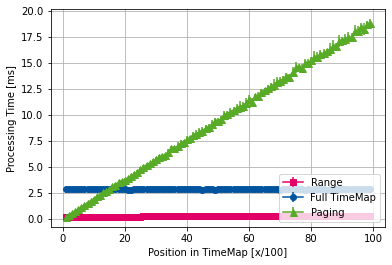

In [7]:
def calcit():
    f=open("exp2.txt", "r")
    exp2 = json.load(f)
    ranges = np.array([[element["range"] for element in item] for item in exp2]).transpose()
    fullmap = np.array([[element["fullMap"] for element in item] for item in exp2]).transpose()
    paging = np.array([[element["page"] for element in item] for item in exp2]).transpose()

    ranges_mc = list(map(mean_confidence_interval, ranges))
    fullmap_mc = list(map(mean_confidence_interval, fullmap))
    paging_mc = list(map(mean_confidence_interval, paging))

    return {"ranges": [mc["mean"] for mc in ranges_mc], "range_errors": [mc["confidence"] for mc in ranges_mc],
            "fullmap": [mc["mean"] for mc in fullmap_mc], "fullmap_errors": [mc["confidence"] for mc in fullmap_mc],
            "paging": [mc["mean"] for mc in paging_mc],  "paging_errors": [mc["confidence"] for mc in paging_mc]}

def plotit(data):
    position = range(1,100,1)

    latency_range = np.array(data["ranges"])
    error_bar_range = np.array(data["range_errors"])

    latency_fullmap = np.array(data["fullmap"])
    error_bar_fullmap = np.array(data["fullmap_errors"])

    latency_page = np.array(data["paging"])
    error_bar_parge = np.array(data["paging_errors"])

    fig, ax = plt.subplots()

    h1 = ax.errorbar(position, latency_range, yerr=error_bar_range, marker="s", label="Range", color="#e30066")
    h2 = ax.errorbar(position, latency_fullmap, yerr=error_bar_fullmap, marker="o", label="Full TimeMap", color="#00549F")
    h3 = ax.errorbar(position, latency_page, yerr=error_bar_parge, marker="^", markersize=7, label="Paging", color="#57ab27")


    #plt.ylim(0,80)

    ax.set(xlabel='Position in TimeMap [x/100]', ylabel='Processing Time [ms]')

    ax.grid()
    ax.legend(loc=4)
    plt.show()

data = calcit()
plotit(data)